# Intro to Data Science Course Project
## Predicting Solar Flares

In [25]:
#packages
from pylab import *
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error

from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

%matplotlib inline

# The data set includes conditions in an area on the sun during 24 hours and how many solar flares of different classes occured. There aren't very many observations of solar flares (compared to no solar flare) so I'm only going to attempt to predict whether a solar flare will happen, and not which class of flare it will be.

## The features are:
* spot_class: Classification for configuration of group of sunspots
* l_spot_size: Classification for the largest sunspot in the group
* spot_dist: Classification for the distribution of the sunspots
 * spot_class, l_spot_size, spot_dist classification letters aren't ordered in any intuitive way, here's a nice image to show what they mean ![alt text](https://www.spaceweatherlive.com/images/help/zonnevlekken_malde/zonnevlekclassificatie.jpg)
* activity: How has the sunspot activity changed? (1/reduced, 2/unchanged)
* evolution: How have the sunspots evolved? (1/decay, 2/no growth, 3/growth)
* prev_activity: Were there any large flares in the last 24 hours? (1 = nothing as big an an M1, 2 = one M1, 3 = more than one M1)
* hist_complex: Has this region been complex? (1/yes, 2/no)
* hist_complex_recent: Did this region become complex on this pass across sun's disk? (1/yes, 2/no)
* area: Area of sunspots (1/small, 2/large)
* l_area: Area of largest spot (1 means <=5, 2 means >5)


In [26]:
#open that data up
#there is no header, so create column names
columns = ['spot_class','l_spot_size','spot_dist','activity','evolution','prev_activity','hist_complex','hist_complex_recent','area','l_area','c_class','m_class','x_class']
sfdf = pd.read_table('flare.data2.txt',delim_whitespace=1,skiprows=1,header=None,names=columns)
sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,l_area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,H,R,X,1,2,1,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,1,0,0,0


### Looks like there's something weird with the area of the largest spot..

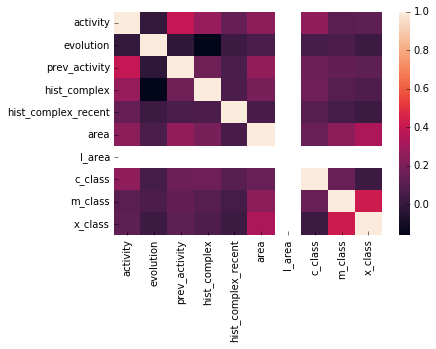

In [27]:
sns.heatmap(sfdf.corr())

In [28]:
#looks like largest area of sunspot always ==1, so no info here
print len(sfdf.index),sum(sfdf.l_area==1)

1066 1066


In [29]:
sfdf.drop('l_area',inplace=1,axis=1)
sfdf.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,c_class,m_class,x_class
0,H,A,X,1,3,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,0,0,0
2,C,S,O,1,3,1,1,2,1,0,0,0
3,H,R,X,1,2,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,0,0,0


### I have a bunch of categorical data, so I need to reformat it into a way the classifier can understand. I replace the classes with dummy features, and make a new column that has a numeric label for the type of flare that occurred during that observation (which will be the target).

In [30]:
#replace categorical features with dummy features, if ordered though leave as numbers
sfdf_clean = sfdf.copy()

#replace sunspot class w/ dummies
#get dummmy features
scd = pd.get_dummies(sfdf.spot_class,drop_first=1,prefix='sc').astype(int)
#add dummy features to df
sfdf_clean = pd.concat([sfdf_clean,scd],axis=1)
#drop old feature
sfdf_clean.drop('spot_class',inplace=1,axis=1)

#replace spot size w/ dummies
ssd = pd.get_dummies(sfdf.l_spot_size,drop_first=1,prefix='lss').astype(int)
sfdf_clean = pd.concat([sfdf_clean,ssd],axis=1)
sfdf_clean.drop('l_spot_size',inplace=1,axis=1)

#replace spot dist w/ dummies
sdd = pd.get_dummies(sfdf.spot_dist,drop_first=1,prefix='sd').astype(int)
sfdf_clean = pd.concat([sfdf_clean,sdd],axis=1)
sfdf_clean.drop('spot_dist',inplace=1,axis=1)

#replace historically-complex w/ dummies
hcd = pd.get_dummies(sfdf.hist_complex,drop_first=1,prefix='hc').astype(int)
sfdf_clean = pd.concat([sfdf_clean,hcd],axis=1)
sfdf_clean.drop('hist_complex',inplace=1,axis=1)

#replace hist-complex-recent w/ dummies
hcrd = pd.get_dummies(sfdf.hist_complex_recent,drop_first=1,prefix='hcr').astype(int)
sfdf_clean = pd.concat([sfdf_clean,hcrd],axis=1)
sfdf_clean.drop('hist_complex_recent',inplace=1,axis=1)

#make new target column
#target (class of flare) = 0 (no flare), 1 (any type of flare)
sfdf_clean['solar_flare'] = zeros(len(sfdf.index),dtype=int)
for index, row in sfdf_clean.iterrows():
    if sum(row[['c_class','m_class','x_class']] ==0) ==3:
        sfdf_clean.loc[index,'solar_flare'] = 0
    else:
        sfdf_clean.loc[index,'solar_flare'] = 1

sfdf_clean.drop(['c_class','m_class','x_class'],inplace=1,axis=1)    
sfdf_clean.head()

,activity,evolution,prev_activity,area,sc_C,sc_D,sc_E,sc_F,sc_H,lss_H,lss_K,lss_R,lss_S,lss_X,sd_I,sd_O,sd_X,hc_2,hcr_2,solar_flare
0,1,3,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,1,3,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0
2,1,3,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
3,1,2,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
4,1,1,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0


In [31]:
#make a cleaned up data frame for plotting
sfdfp = pd.concat([sfdf,sfdf_clean['solar_flare']],axis=1)
number = preprocessing.LabelEncoder()
sfdfp['spot_class'] = number.fit_transform(sfdfp['spot_class'].astype('str'))
sfdfp['l_spot_size'] = number.fit_transform(sfdfp['l_spot_size'].astype('str'))
sfdfp['spot_dist'] = number.fit_transform(sfdfp['spot_dist'].astype('str'))
sfdfp.head()

,spot_class,l_spot_size,spot_dist,activity,evolution,prev_activity,hist_complex,hist_complex_recent,area,c_class,m_class,x_class,solar_flare
0,5,0,3,1,3,1,1,1,1,0,0,0,0
1,2,3,2,1,3,1,1,2,1,0,0,0,0
2,1,4,2,1,3,1,1,2,1,0,0,0,0
3,5,3,3,1,2,1,1,1,1,0,0,0,0
4,5,4,3,1,1,1,1,2,1,0,0,0,0


### Let's visualize that data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b3e2e90>]], dtype=object)

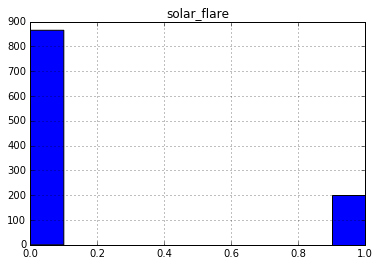

In [32]:
#before combining the classes of flares into one variable, there were only 4 observations of x-class
#~900 no flares, ~200 flares
sfdfp.hist(column='solar_flare')

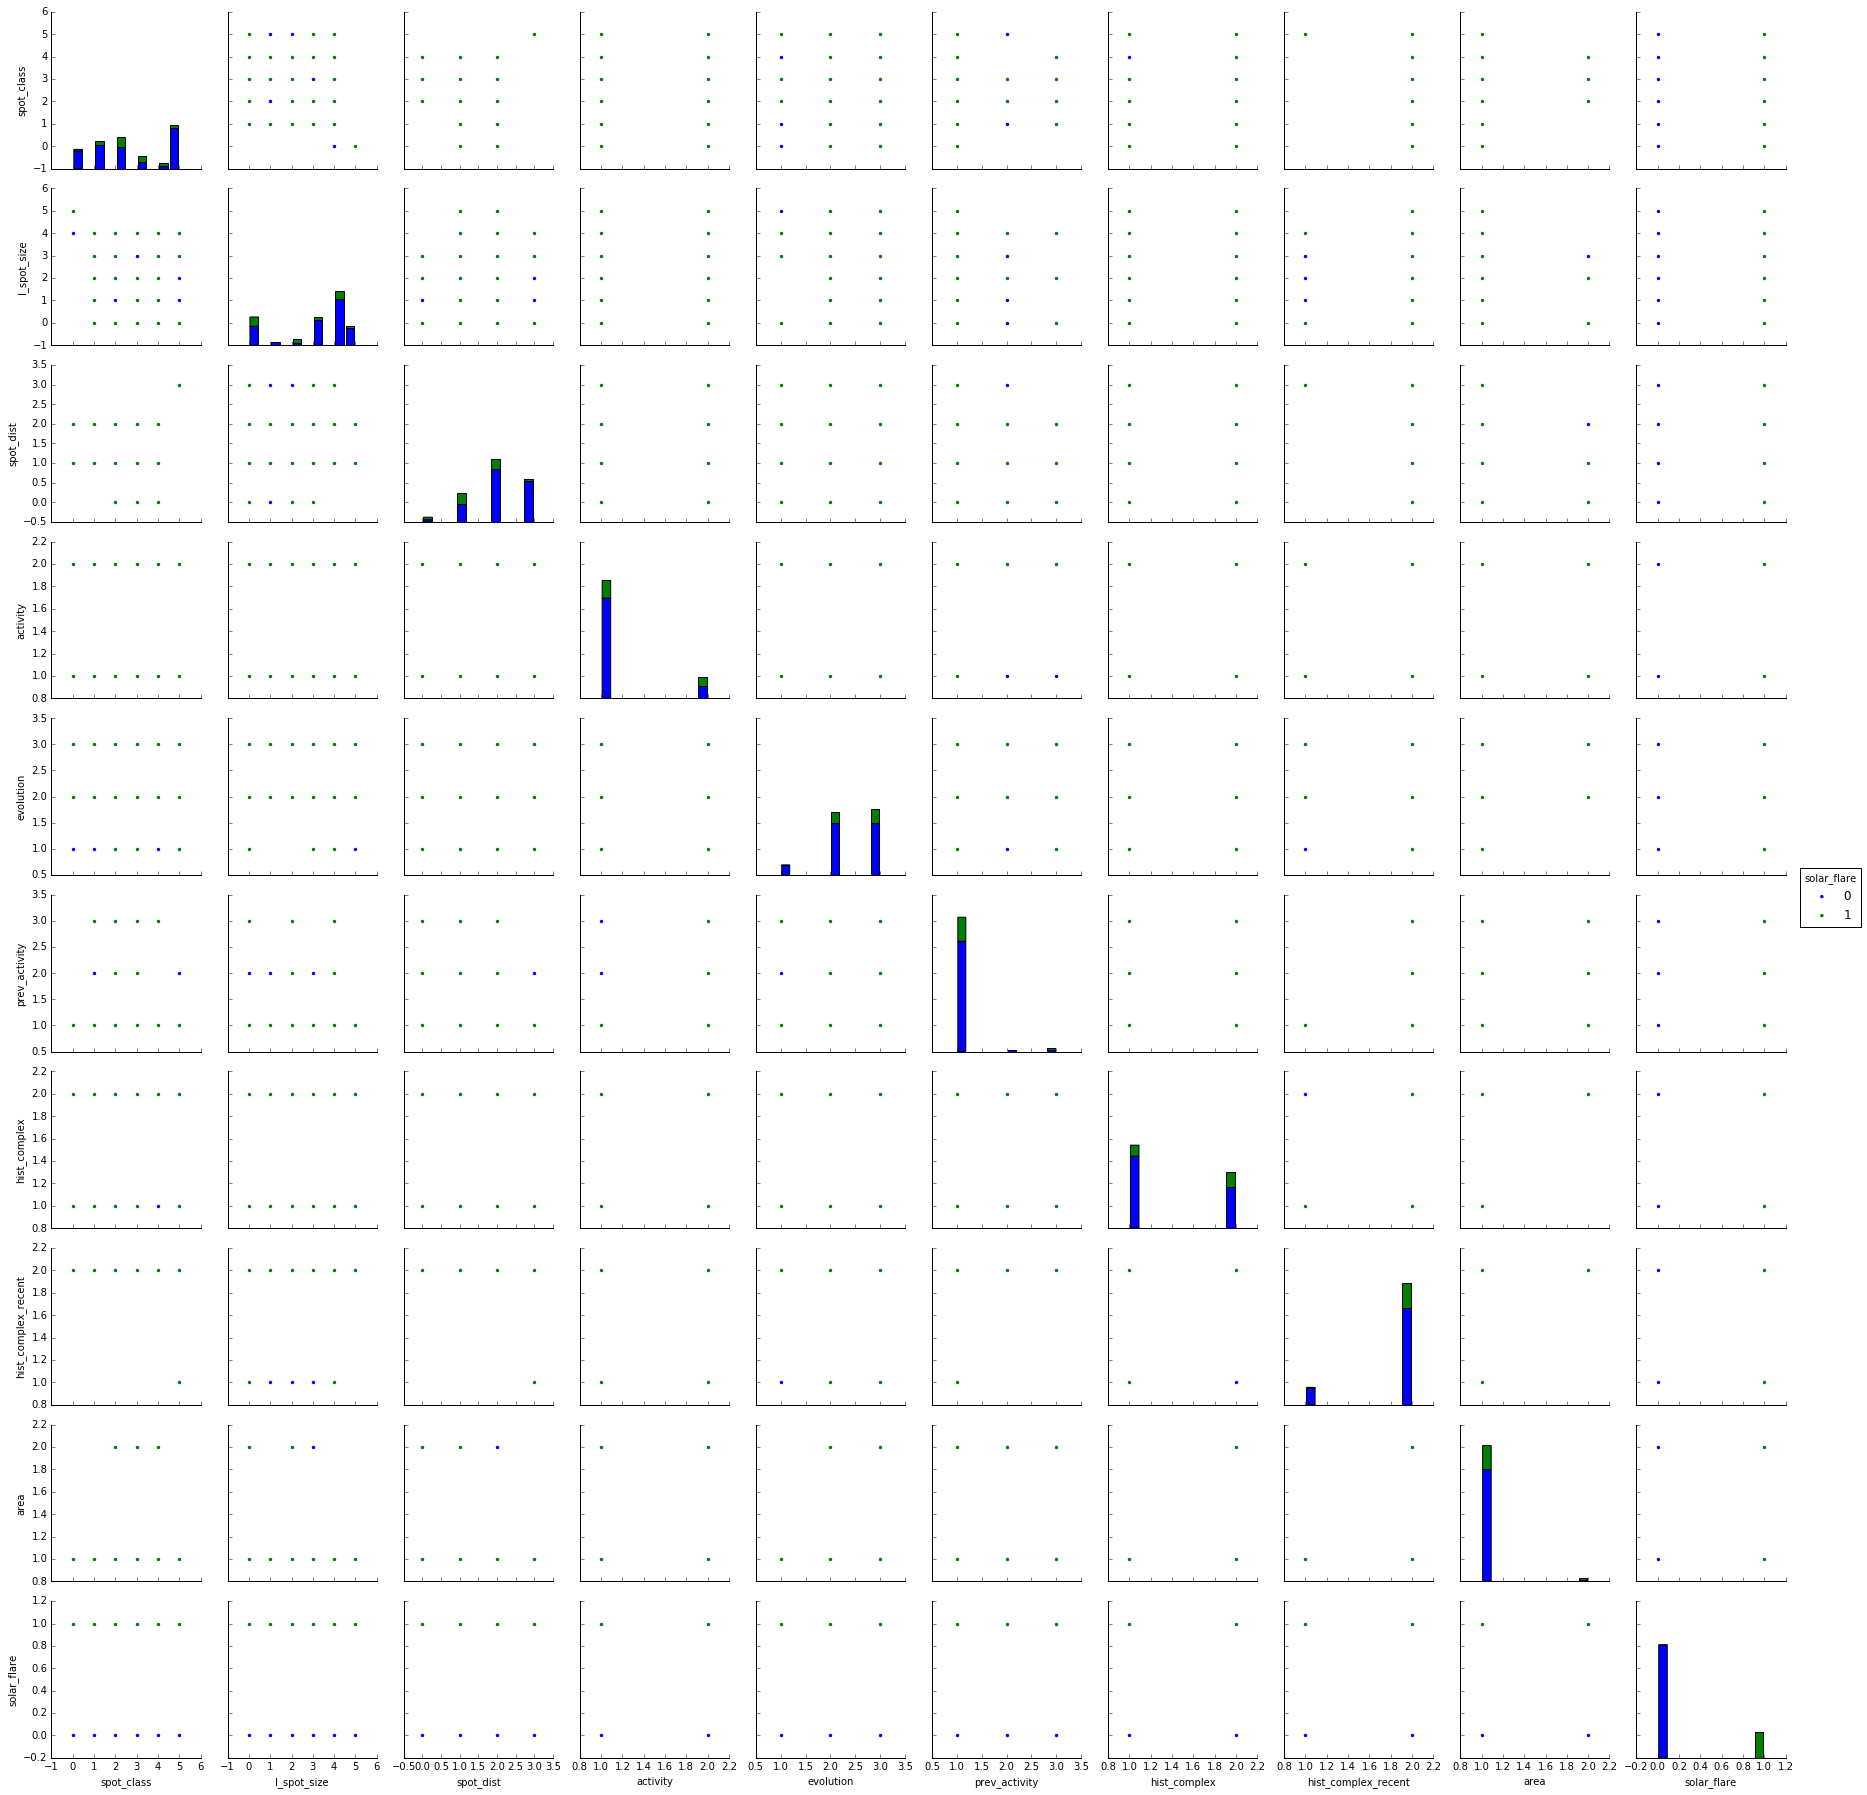

In [33]:
pcols = ['spot_class', 'l_spot_size', 'spot_dist', 'activity', 'evolution', 'prev_activity', 'hist_complex', 'hist_complex_recent', 'area', 'solar_flare']
sns.pairplot(data=sfdfp[pcols],hue='solar_flare')

In [236]:
#wow this is so slow
'''fig = figure()
s = 1
for i,j in enumerate(pcols[-3:]):
    for k,l in enumerate(pcols[-3:]):
        print i,k,j,l
        if k != i:
            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)
            sns.swarmplot(x=j,y=l,hue='solar_flare',data=sfdfp,ax=ax1)
            ax1.set_xlabel(j)
            ax1.set_ylabel(l)
            s+=1
        if k==i:
            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)
            sfdfp.hist(column=pcols[i],ax=ax1)           
            ax1.set_xlabel(j)
            s+=1
'''            

"fig = figure()\ns = 1\nfor i,j in enumerate(pcols[-3:]):\n    for k,l in enumerate(pcols[-3:]):\n        print i,k,j,l\n        if k != i:\n            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)\n            sns.swarmplot(x=j,y=l,hue='solar_flare',data=sfdfp,ax=ax1)\n            ax1.set_xlabel(j)\n            ax1.set_ylabel(l)\n            s+=1\n        if k==i:\n            ax1 = fig.add_subplot(len(pcols[-3:]),len(pcols[-3:]),s)\n            sfdfp.hist(column=pcols[i],ax=ax1)           \n            ax1.set_xlabel(j)\n            ax1.set_ylabel(l)\n            s+=1\n"

spot_class
l_spot_size
spot_dist
activity
evolution
prev_activity
hist_complex
hist_complex_recent
area


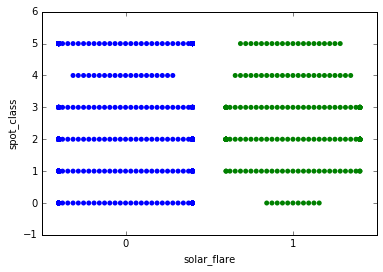

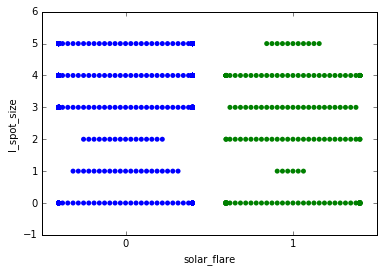

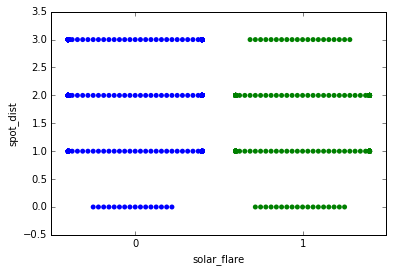

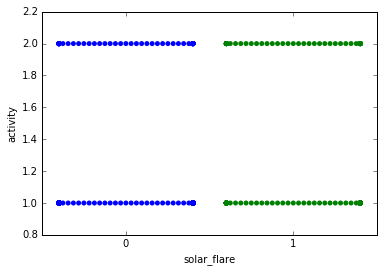

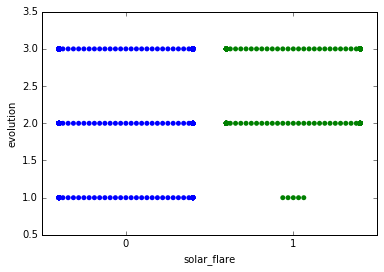

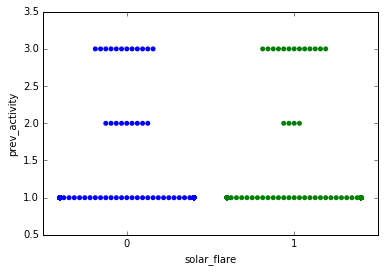

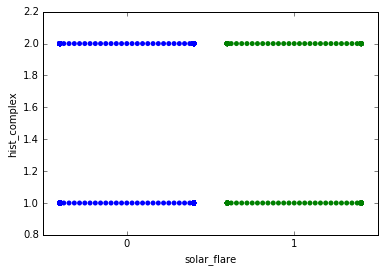

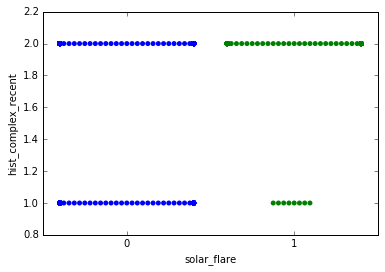

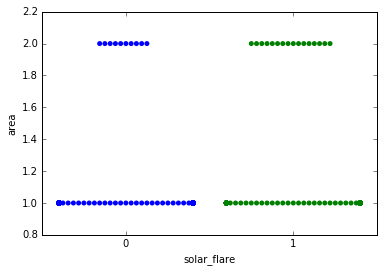

In [11]:
for i in pcols[:-1]:
    print i
    figure()
    sns.swarmplot(x='solar_flare',y=i,data=sfdfp)

In [34]:
#get training/test sets
cols = sfdf_clean.columns[sfdf_clean.columns!='solar_flare']
X = sfdf_clean[cols]
y = sfdf_clean.solar_flare
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [36]:
#fit logistic regression classifier
logreg = LogisticRegression(random_state=0)
logreg.fit(X_train,y_train)
print 'accuracy w/ train data =', logreg.score(X_train,y_train)
print 'accuracy w/ test data =', logreg.score(X_test,y_test)
#print(metrics.classification_report(y_test,logreg.predict(X_test)))
#print 'err:', sqrt(mean_squared_error(y_test,logreg.predict(X_test)))
cmlr = metrics.confusion_matrix(y_test, logreg.predict(X_test))
print cmlr



#try w/ cross validation
#compute cross-validation score accuracy across 10 folds
cvslogreg = cross_val_score(logreg,X,y,cv=10)
#print "10-fold accuracies:\n",cvslogreg
print "Mean cv-accuracy:",mean(cvslogreg)
print "Std of cv-accuracy:",std(cvslogreg)

accuracy w/ train data = 0.822277847309
accuracy w/ test data = 0.846441947566
[[215   9]
 [ 32  11]]
Mean cv-accuracy: 0.810488547973
Std of cv-accuracy: 0.0139778136074


### Looks like the spot class/largest spot class has a large impact

In [37]:
#examine coefficients
coef = array(zip(cols, logreg.coef_[0]))
coef=coef[argsort(coef[:,1])][::-1]
coef

array([['lss_K', '0.79470310718'],
       ['sc_F', '0.606643203225'],
       ['sc_E', '0.60579352588'],
       ['activity', '0.426584926481'],
       ['sc_D', '0.340815941117'],
       ['evolution', '0.198080412325'],
       ['prev_activity', '0.0395461098714'],
       ['lss_X', '-1.00149500655'],
       ['sc_H', '-0.888128582734'],
       ['sd_X', '-0.888128582734'],
       ['sd_O', '-0.671045103662'],
       ['lss_R', '-0.547107774894'],
       ['area', '-0.529080310101'],
       ['lss_S', '-0.359580627606'],
       ['sd_I', '-0.262822575856'],
       ['sc_C', '-0.221008024794'],
       ['hc_2', '-0.0948663546771'],
       ['hcr_2', '-0.0782808373513'],
       ['lss_H', '-0.0499993281783']], 
      dtype='|S16')

In [38]:
#try w/ random forest
#Random forest of 500 trees
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
print 'accuracy w/ train data =', rf.score(X_train,y_train)
print 'accuracy w/ test data =', rf.score(X_test,y_test)
#print metrics.classification_report(y_test,rf.predict(X_test))
#print 'err:', sqrt(mean_squared_error(y_test,rf.predict(X_test)))
cmrf = metrics.confusion_matrix(y_test, rf.predict(X_test))
print cmrf

cvsrf = cross_val_score(rf,X,y,cv=10)
#print "10-fold accuracies:\n",cvsrf
print "Mean cv-accuracy:",mean(cvsrf)
print "Std of cv-accuracy:",std(cvsrf)

accuracy w/ train data = 0.876095118899
accuracy w/ test data = 0.816479400749
[[207  17]
 [ 32  11]]
Mean cv-accuracy: 0.778580431957
Std of cv-accuracy: 0.0382024807892


### It looks like evolution (if the sunspot has become larger/smaller/unchanged) was the most important feature. Previous activity, complexity, and largest spot size were the next important features.

In [39]:
#how important is each feature
fi = array(zip(sfdf_clean[cols], rf.feature_importances_))
fi=fi[argsort(fi[:,1])][::-1]
fi

array([['evolution', '0.133192768431'],
       ['activity', '0.0907791374018'],
       ['lss_S', '0.0857865866205'],
       ['sd_I', '0.0855830279591'],
       ['lss_K', '0.0784655051553'],
       ['prev_activity', '0.0733363368878'],
       ['sd_O', '0.0716654435852'],
       ['hc_2', '0.0707880733055'],
       ['sc_E', '0.0575125492294'],
       ['lss_R', '0.0472173260683'],
       ['sd_X', '0.0435082290971'],
       ['sc_F', '0.0372265353185'],
       ['sc_D', '0.0357565720061'],
       ['area', '0.0236791423147'],
       ['lss_H', '0.0226819855434'],
       ['sc_C', '0.0155588755012'],
       ['lss_X', '0.014705187223'],
       ['hcr_2', '0.0118714849679'],
       ['sc_H', '0.000685233384161']], 
      dtype='|S17')

### Let's see how it compares to a dummy classifier
#### .... uh oh

In [41]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
ydpred = dummy.predict(X_test)
print metrics.accuracy_score(y_test, ydpred)
cmd = metrics.confusion_matrix(y_test, ydpred)
print cmd



0.838951310861
[[224   0]
 [ 43   0]]
